### imports

In [70]:
from tpot import TPOTClassifier, TPOTRegressor
import dill
import pandas as pd

from configparser import ConfigParser
import numerapi
import os
import sys
if not os.getcwd().endswith('trading'): os.chdir('../../../../trading') # local machine
assert os.getcwd().endswith('trading'), 'Wrong path!'
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from collections import Counter
from skimpy import clean_columns

import multiprocessing as mp
from sklearn.metrics import mean_squared_error
from pandarallel import pandarallel # parallel pandas
import time
import numpy as np
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer

import platform
from datetime import datetime
from sklearn.base import TransformerMixin
if platform.system() != 'Windows':
    mp.set_start_method('forkserver')
sys.path.append(os.getcwd())
import matplotlib.pyplot as plt

In [35]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### load the model

In [61]:
model_dict = dill.load(open('/media/melgazar9/HDD_10TB/trading/objects/XGBRegressor_2022-03-17_16_28_00.pkl', 'rb'))

In [11]:
model_dict.keys()

dict_keys(['model', 'df_pred', 'feature_creator', 'feature_transformer', 'input_features', 'final_features', 'final_dtype_mapping', 'dropped_features', 'input_df'])

### global variables

In [18]:
TARGET = 'target_20d'
PRESERVE_VARS = ['XGBRegressor_pred', 'target_4d', 'yahoo_ticker', 'date_localized', 'dataset_split']
ID_VARS = ['date']

DROP_COLS = model_dict['dropped_features'] # [i for i in model_dict['df_pred'].columns if is_datetime(model_dict['df_pred'][i]) and i not in ID_VARS + PRESERVE_VARS]
OBJECT_COLS = [i for i in model_dict['df_pred'].columns if model_dict['df_pred'][i].dtype == 'object' and i not in ID_VARS + PRESERVE_VARS]

In [19]:
try:
    model_dict['df_pred'].set_index(ID_VARS, inplace=True)
except:
    pass
try:
    model_dict['df_pred'].drop(DROP_COLS, axis=1, inplace=True)
except:
    pass

### train test split

In [27]:
X_train = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train'][model_dict['input_features']]
y_train = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train'][TARGET]

X_val = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val'][model_dict['input_features']]
y_val = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val'][TARGET]

X_test = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test'][model_dict['input_features']]
y_test = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test'][TARGET]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((936205, 813), (936205,), (201196, 813), (201196,), (204094, 813), (204094,))

In [62]:
X_train.head(2)

,open_1h_2_diff,high_move_pct_1h_4,range_1h_3,low_move_pct_1h_11_ewm_mean,adj_close_1h_2_pct_change,low_1h_5_pct_change,open_1h_3_pct_change,dayofweek_pct_change,low_move_1h_7_ewm_mean,high_move_pct_change_1h_3_rolling_mean,...,high_1h_6_diff,volume_1h_4,high_minus_prev_close_1h_2,high_move_pct_1h_10,low_move_pct_change_1h_9_rolling_mean,high_move_1h_9_ewm_mean,low_move_pct_1h_6_ewm_mean,low_move_1h_1_rolling_mean,low_move_pct_1h_12_ewm_mean,move_pct_change_1h_14
date,,,,,,,,,,,,,,,,,,,,,
2015-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
X_train_transformed = pd.DataFrame(model_dict['feature_transformer'].transform(X_train), columns=model_dict['final_features'])
X_val_transformed = pd.DataFrame(model_dict['feature_transformer'].transform(X_val), columns=model_dict['final_features'])
X_test_transformed = pd.DataFrame(model_dict['feature_transformer'].transform(X_test), columns=model_dict['final_features'])

/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 1, 6, 10, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 34, 35, 36, 38, 40, 43, 44, 45, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 1, 6, 10, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 34, 35, 36, 38, 40, 43, 44, 45, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### basic model metrics

In [30]:
print('\nTrain xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['target_20d']))))

print('Train xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['target_20d']))))

print('Train xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['target_20d']))))



Train xgboost RMSE: 0.21952151803234238

Train xgboost RMSE: 0.21672828832361798

Train xgboost RMSE: 0.21214639522304019



In [43]:
model_dict['df_pred'][['XGBRegressor_pred']].describe()

,XGBRegressor_pred
count,1341495.00000
mean,0.50458
std,0.03052
min,0.19821
25%,0.48830
50%,0.50438
75%,0.52005
max,0.82168


<AxesSubplot:ylabel='Frequency'>

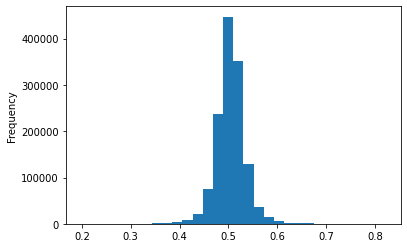

In [44]:
model_dict['df_pred']['XGBRegressor_pred'].plot(kind='hist', bins=30)

<AxesSubplot:ylabel='Frequency'>

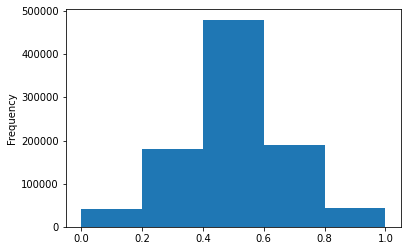

In [60]:
y_train.plot(kind='hist', bins=5)

## The bread and butter - numerai signals evaluation metrics
These metrics determine how good the model really is and gives a solid estimation on how much we will get paid out if we deployed this particular model

In [65]:
def calc_basic_metrics(y_pred):
    print(f"Mean Correlation: {y_pred.mean():.3f}")
    print(f"Median Correlation: {y_pred.median():.3f}")
    print(f"Standard Deviation: {y_pred.std():.3f}")
    print('\n')
    print(f"Mean Pseudo-Sharpe: {y_pred.mean()/y_pred.std():.3f}")
    print(f"Median Pseudo-Sharpe: {y_pred.median()/y_pred.std():.3f}")
    print('\n')
    print(f'Hit Rate (% positive eras): {y_pred.apply(lambda x: np.sign(x)).value_counts()[1]/len(y_pred):.2%}')

    y_pred.rolling(10).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,5))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    y_pred.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,5))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()
    
def calculate_fnc(sub, targets, features):
    """    
    Args:
        sub (pd.Series)
        targets (pd.Series)
        features (pd.DataFrame)
    """

    # Normalize submission
    sub = (sub.rank(method="first").values - 0.5) / len(sub)

    # Neutralize submission to features
    f = features.values
    sub -= f.dot(np.linalg.pinv(f).dot(sub))
    sub /= sub.std()

    sub = pd.Series(np.squeeze(sub)) # Convert np.ndarray to pd.Series

    # FNC: Spearman rank-order correlation of neutralized submission to target
    fnc = np.corrcoef(sub.rank(pct=True, method="first"), targets)[0, 1]

    return fnc

In [72]:
class CalcNumeraiMetrics:
    
    def __init__(self, y, y_pred):
        self.y = y
        self.y_pred = y_pred
    
    def calc_coef(self):

        # method="first" breaks ties based on order in array
        return np.corrcoef(self.y, self.y_pred.rank(pct=True, method="first"))[0,1]
    
    def calc_mmc(self):
        pass
    
    def calc_estimated_payout(self, stake_value, payout_factor, corr, corr_multiplier, mmc, mmc_multiplier):
        estimated_payout = stake_value * payout_factor * (corr * corr_multiplier + mmc * mmc_multiplier)
        return estimated_payout

In [81]:
CalcNumeraiMetrics(model_dict['df_pred']['XGBRegressor_pred'], model_dict['df_pred']['XGBRegressor_pred']).calc_coef()

0.9034509923617006

Mean Correlation: 0.505
Median Correlation: 0.504
Standard Deviation: 0.031


Mean Pseudo-Sharpe: 16.532
Median Pseudo-Sharpe: 16.525


Hit Rate (% positive eras): 100.00%


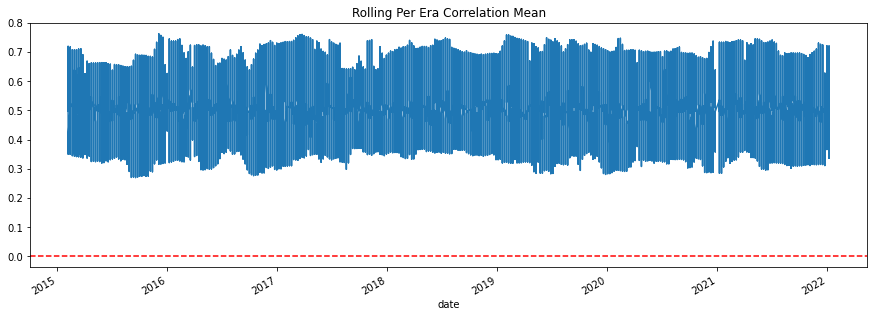

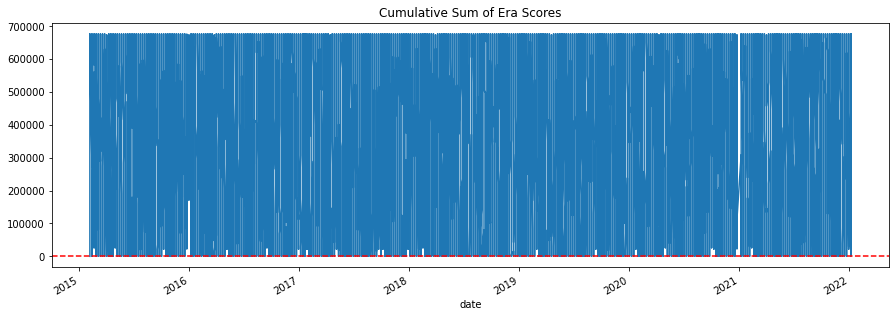

In [71]:
calc_basic_metrics(model_dict['df_pred']['XGBRegressor_pred'])